<a href="https://colab.research.google.com/github/YaninaK/anomaly-detection/blob/b1/notebooks/03_Anomalies_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение аномалий в начислениях за тепловую энергию


## 2. Аномалии 3.1. Выбор длины последовательности, обогащение признаков, предварительная разметка.


### Примеры аномалий

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);

2. равные значения показаний в течение нескольких расчетных периодов;

3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);

4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
  - год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
  - этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
  - площадь (±10%),
  - наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1  https://github.com/YaninaK/anomaly-detection.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/08_anomaly_detection/data/01_raw/task#3.zip -d /content/anomaly-detection/data/01_raw

%cd /content/anomaly-detection/notebooks

/content/anomaly-detection/notebooks


In [2]:
import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "..", "src", "anomaly_detection"))

In [3]:
import datetime
import joblib
import tempfile

import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from data.make_dataset import load_data
from data.preprocess import Preprocess
from data.data_sequence import generate_data_sequence
from features.missing_records import (
    select_missing_records, select_uninvoiced_objects, select_nonunique_objects
)
from features.duplicated import get_equal_values
from features.objects_grouping import ObjectsGrouping
from features.model_inputs import Generator

from models.autoencoder import get_autoencoder
from models.utilities import plot_loss, plot_metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH = "/content/anomaly-detection/"

## 1. Чтение данных

In [6]:
folder_path = '../data/01_raw/'

In [7]:
regenerate = True
data, temperature, buildings = load_data(folder_path, regenerate, path=PATH)

100%|██████████| 24/24 [00:14<00:00,  1.65it/s]


## 2. Подготовка данных

In [8]:
preprocess = Preprocess()
data, buildings, temperature = preprocess.fit_transform(data, buildings, temperature)

data.shape

(75385, 10)

In [9]:
df = generate_data_sequence(data)

print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)



,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,01333161850,0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,6.13,NaN,NaN,NaN,NaN,NaN
"г Уфа, ул. Бессонова, д.21",Многоквартирный дом,1401100,1,"г Уфа, ул. Бессонова, д.21",136.06,145.893,113.719,654.8,528.787,792.51,963.318,807.747,NaN,NaN,...,0.0,761.046,873.793,845.606,0.00,0.0,0.0,0.0,0.0,0.0


In [10]:
temperature.sample(2)

Период,"Тн.в, град.С",ОЗП,Число дней
index,,,
2021-10-01,6.696552,1,29.0
2023-02-01,-8.944828,1,29.0


In [11]:
n_periods = len(df)
df.iloc[:, -n_periods:] = np.where(df.iloc[:, -n_periods:] == 0, np.nan, df.iloc[:, -n_periods:])
df /= temperature["Число дней"]

print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)



,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, пр-кт Октября, д.21",Многоквартирный дом,1401963,1,"г Уфа, пр-кт Октября, д.21",0.135903,0.248,0.608344,3.781552,3.886710,4.485133,5.151387,4.673214,4.275918,2.970765,...,0.577824,2.275259,3.856645,5.463567,5.530839,5.091828,4.163100,3.007000,0.508517,0.404333
"г Уфа, ул. Адмирала Ушакова, д.64 корп.1",Многоквартирный дом,93047,0,"г Уфа, ул. Адмирала Ушакова, д.64 корп.1",NaN,NaN,NaN,1.774517,2.654839,3.514000,4.301290,3.364286,3.062742,1.692647,...,NaN,1.646667,2.632323,4.149300,4.126710,3.540241,2.432633,1.625906,NaN,NaN


## 3. Сопоставление данных о потребленнии теплоэнергии и данных об объектах

### 3.1 Более одного объекта на одном ```№ ОДПУ```

In [12]:
df_comb = (
    buildings.merge(
        df.reset_index(),
        left_on=["Тип Объекта", "Адрес объекта 2"],
        right_on=["Тип объекта", "Адрес объекта 2"],
        how="right",
    )
    .drop_duplicates(
        subset=["Адрес объекта_y", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"],
        keep=False,
    )
)
df_comb.shape[0] - df.shape[0]

-74

* У 74 объектов типа ```Другое строение```  на один ```№ ОДПУ``` привязано более одного объекта разной этажности. Эти объекты исключены из обучающей выборки.

### 3.2 Отсутствуют данные об объектах

In [13]:
selected = ["Адрес объекта", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"]
(
    df_comb[df_comb["Адрес объекта_x"].isnull()]
    .rename(columns={"Адрес объекта_y": "Адрес объекта"})[selected]
    .sort_values(by=["Тип объекта", "Адрес объекта"])
    .reset_index(drop=True)
)

,Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС
0,"г Уфа, ул. Новоженова, д.88 корп.литер 1, Подо...","Административные здания, конторы",255257,0
1,г Уфа,Другое строение,787,1
2,"г Уфа, пр-кт Октября, д.18 корп.3а",Другое строение,247280,0
3,"г Уфа, ул. Войкова, д.2",Другое строение,103243,0
4,"г Уфа, ул. Дмитрия Донского, д.1 корп.4",Другое строение,189082,0
5,"г Уфа, ул. Кислородная, д.7, Подобъект №983475",Другое строение,1600800,0
6,"г Уфа, ул. Кулибина, д.40",Другое строение,1108050,0
7,"г Уфа, ул. Максима Горького, д.69 корп.1",Другое строение,98266,0
8,"г Уфа, ул. Николая Дмитриева, д.19 корп.1",Другое строение,1544202,0
9,"г Уфа, ул. Пархоменко, д.125",Другое строение,1668,0


* У 24 объектах из данных о потреблении теплоэнергии отсутствуют данные в базе объектов. Эти объекты исключены из обучающей выборки

In [14]:
df_comb = df_comb[df_comb["Адрес объекта_x"].notnull()].reset_index(drop=True)

df_comb.shape[0] - df.shape[0]

-98

In [15]:
df_comb.shape

(4530, 34)

## 4. Формирование обучающей и тестовой выборки

### 4.1 Формирование датасета

In [16]:
df_stat = df_comb[
    [
        "Адрес объекта 2",
        "Тип объекта",
        "№ ОДПУ",
        "Вид энерг-а ГВС",
        "Этажность объекта",
        "Дата постройки",
        "Общая площадь объекта",
    ]
]
df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта
857,"г Уфа, ул. Айская, д.69 корп.2",Многоквартирный дом,00101840,0,5.0,1971-01-01,3556.7
3740,"г Уфа, ул. Свободы, д.18",Многоквартирный дом,114184,0,5.0,1960-01-01,3526.7


In [17]:
n_periods = 24
df_seq = df_comb.iloc[:, -n_periods:] / temperature["Число дней"]

df_seq.sample(2)

,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
2485,NaN,NaN,NaN,0.032996,0.061935,0.080070,0.100576,0.087165,0.077624,0.036376,...,NaN,0.036250,0.054150,0.096583,0.102751,0.087796,0.060131,0.035294,NaN,NaN
2560,NaN,NaN,NaN,0.206062,0.268513,0.329034,0.392232,0.356483,0.288715,0.149908,...,NaN,0.152213,0.254296,0.414597,0.380368,0.371987,0.258658,0.142496,NaN,NaN


### 4.2 Выбор длины последовательности

In [18]:
def get_max_sequence_length(x):
  max_length = 0
  current_length = 0
  for number in x:
    if np.isnan(number):
      current_length = 0
    else:
      current_length += 1
    if current_length > max_length:
        max_length = current_length

  return max_length

In [19]:
n = df_seq.shape[0]
seq_length = df_seq.T.apply(get_max_sequence_length)
print(f"Всего {n} объектов")
print(f"Потеря объектов обучающей выборки при длине непрерывной последовательности:")
for i in range(3, 8):
  print(f"{i}: {n - df_seq[seq_length >= i].shape[0]}")

Всего 4530 объектов
Потеря объектов обучающей выборки при длине непрерывной последовательности:
3: 131
4: 201
5: 271
6: 358
7: 509


* Оптимальная длина последовательности - 4: по трем точкам будем предсказвыать четвертую.

In [20]:
seq_length = 4

### 4.3 Создание обучающей, тестовой и валидационной выборок

* Для тестирования модели оставим 4 месяца: два - в отопительный сезон, два - за пределами отопительного сезона.
* Для валидации - один месяц.

In [21]:
t, v = 4, 1
train = df_seq.iloc[:,:-t-v]
valid = df_seq.iloc[:, -t-v-seq_length+1:-t]
test = df_seq.iloc[:,-t-seq_length+1:]


print(f"Обучающая выборка с{train.columns[0]: '%Y-%m'}до{train.columns[-1]: '%Y-%m'}")
print(f"Валидационная выборка с{valid.columns[0]: '%Y-%m'}до{valid.columns[-1]: '%Y-%m'}")
print(f"Тестовая выборка с{test.columns[0]: '%Y-%m'}до{test.columns[-1]: '%Y-%m'}\n")

train.shape, valid.shape, test.shape

Обучающая выборка с '2021-07'до '2023-01'
Валидационная выборка с '2022-11'до '2023-02'
Тестовая выборка с '2022-12'до '2023-06'



((4530, 19), (4530, 4), (4530, 7))

### 4.4. Нормализация температуры

In [22]:
temperature["t_scaled"] = np.nan
t_ = temperature["Тн.в, град.С"].values.reshape(-1, 1)
scaler = MinMaxScaler()
temperature.iloc[:-t, -1] = scaler.fit_transform(t_[:-t])
temperature.iloc[-t:, -1] = scaler.transform(t_[-t:])
temperature.sample(3)

Период,"Тн.в, град.С",ОЗП,Число дней,t_scaled
index,,,,
2022-02-01,-6.735714,1,28.0,0.159211
2022-03-01,-5.151613,1,31.0,0.201179
2023-01-01,-12.745161,1,31.0,0.000000


### 4.5. Cтатические признаки

In [23]:
grouping = ObjectsGrouping()
df_stat = grouping.fit_transform(df_stat)

df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта
3565,"г Уфа, ул. Российская, д.163",Многоквартирный дом,107182,0,9.0,1982-01-01,3787.6,5-9 этажей,ул. Российская,1982-01-01,1959-1989 гг.,3800
3798,"г Уфа, ул. Сельская, д.3",Многоквартирный дом,00247354,1,10.0,2014-01-01,14828.8,10-12 этажей,ул. Сельская,2014-01-01,2011-2024 гг.,25000


### 4.6. Tensorflow dataset

In [24]:
%%time
generator = Generator()
ds_train = generator.fit_transform(train, temperature, df_stat)
ds_valid = generator.fit_transform(valid, temperature, df_stat)
ds_test = generator.fit_transform(test, temperature, df_stat)

CPU times: user 13.5 s, sys: 145 ms, total: 13.7 s
Wall time: 13.8 s


In [25]:
ds_train.batch(1).take(1)

<_TakeDataset element_spec=({'n_floors': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'area': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'area_group': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'object_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'floor_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'year_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'street': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gvs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'LSTM input': TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None))>

In [26]:
#next(iter(ds_train.take(1)))
#list(ds_train.as_numpy_iterator())

## 5. Модель

In [27]:
model = get_autoencoder(df_stat)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 4, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 22)             │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group_prep          │ (None, 6)              │              0 │ floor_group[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group_prep           │ (None, 6)              │              0 │ year_group[0][0]       │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 221)            │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gvs (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output1 (LSTM

 Total params: 33,577 (131.17 KB)

 Trainable params: 33,571 (131.14 KB)

 Non-trainable params: 6 (32.00 B)

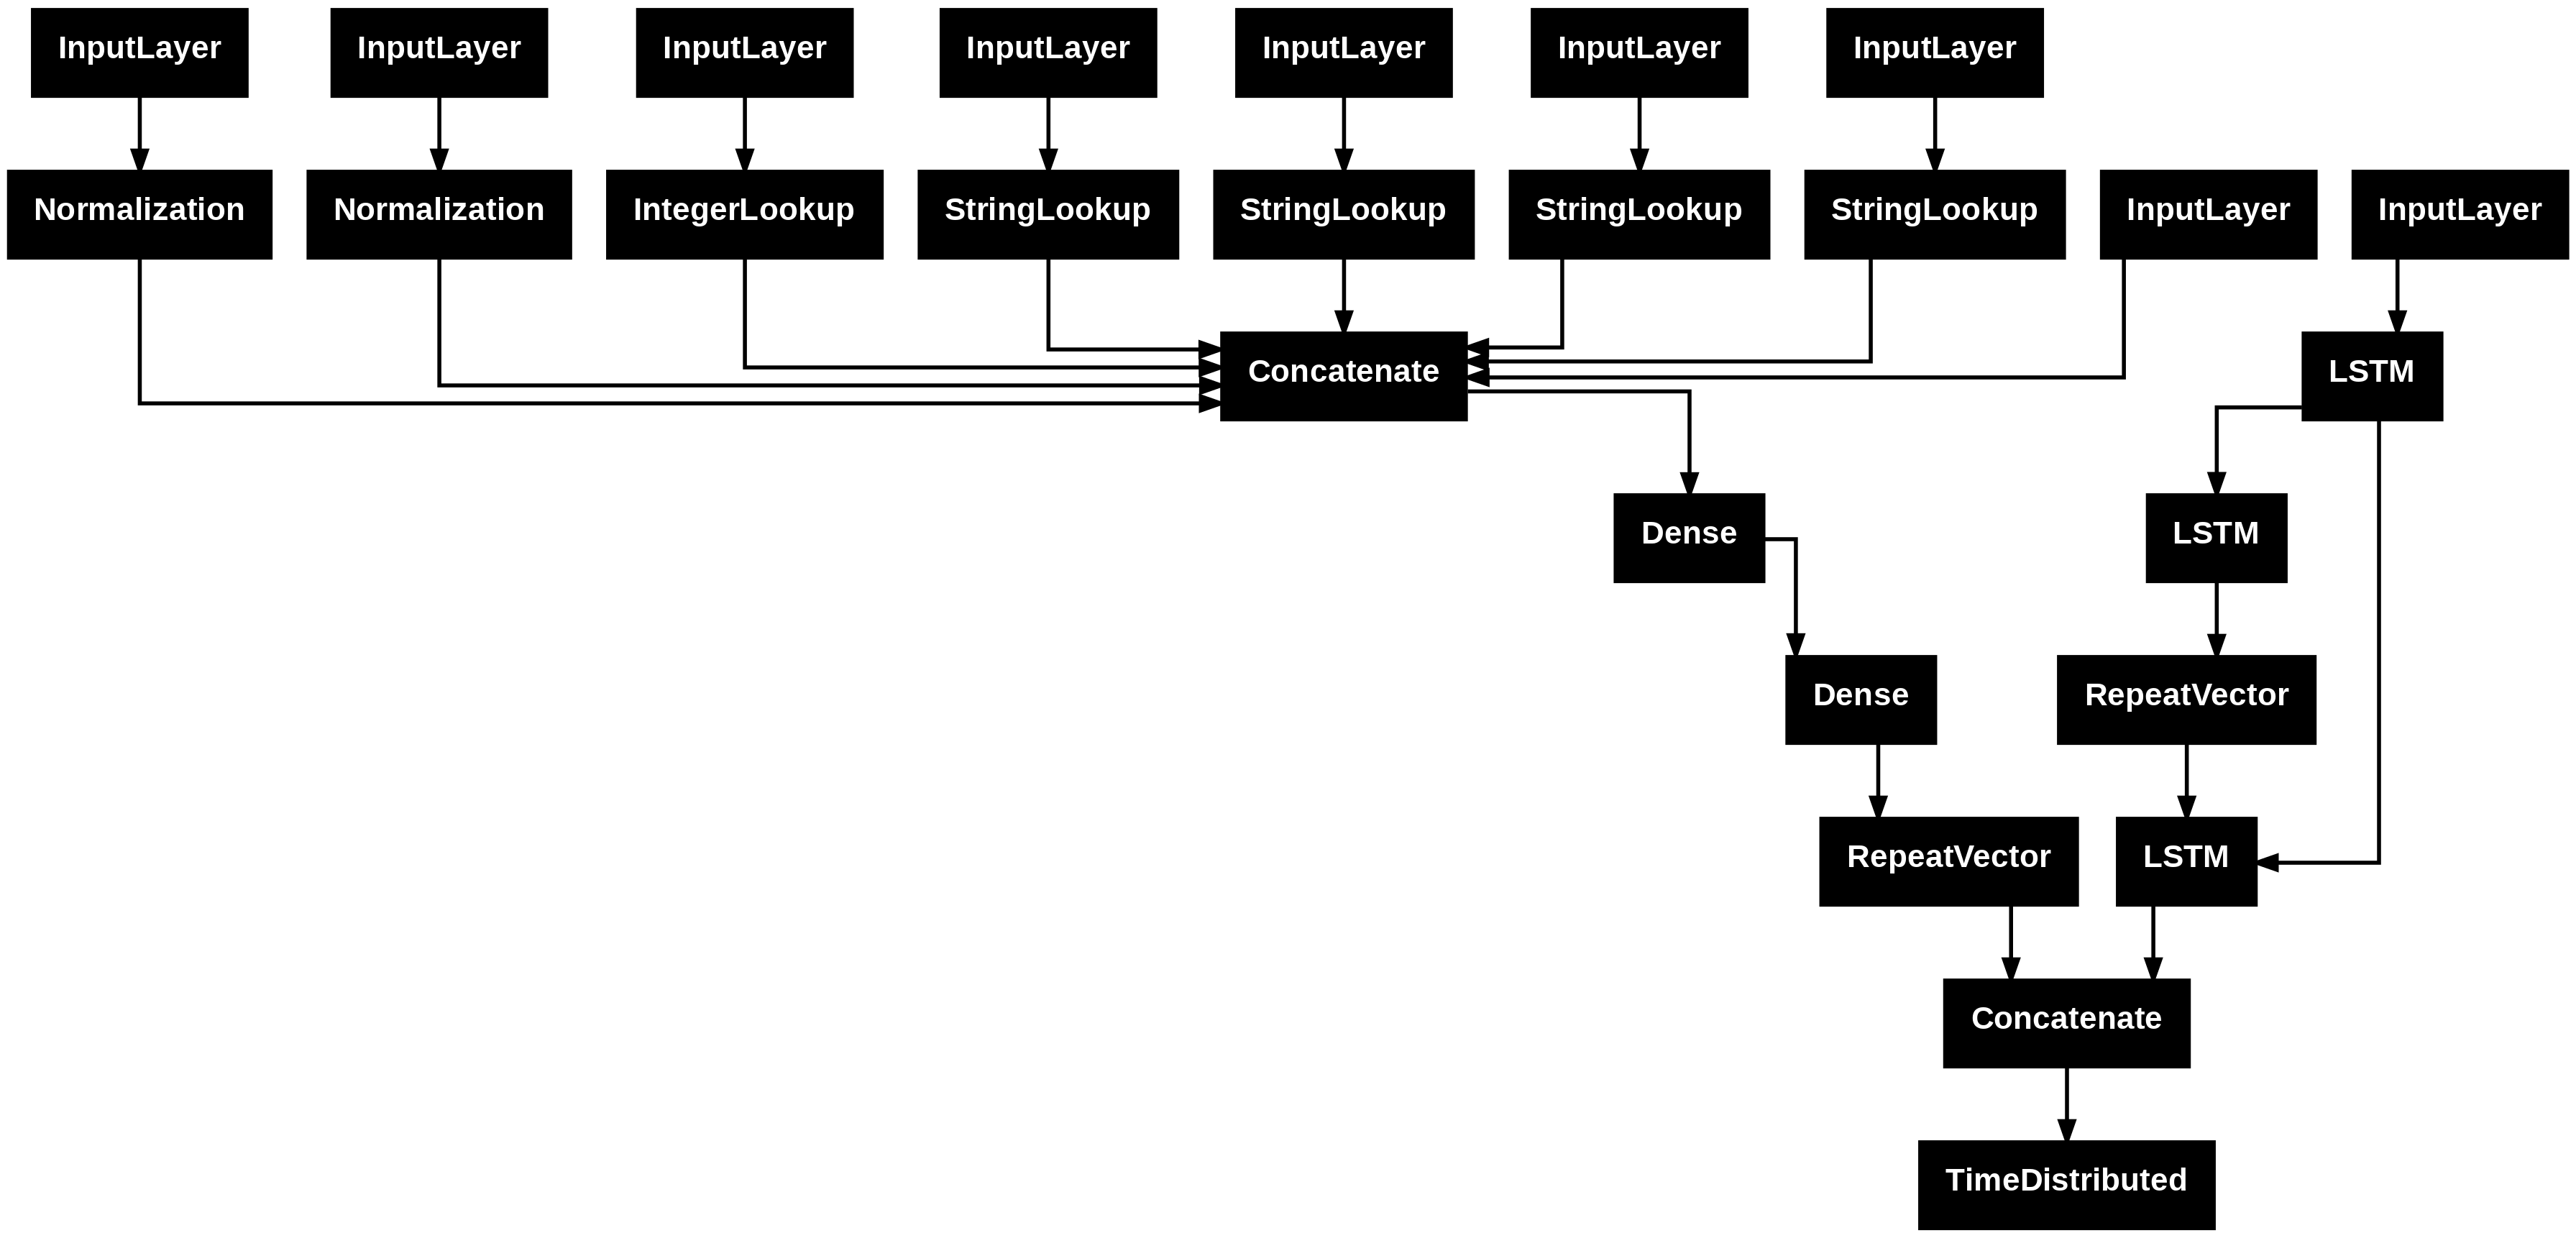

In [28]:
tf.keras.utils.plot_model(model)

## 6. Обучение модели

In [29]:
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
    tf.keras.metrics.MeanSquaredError(name="mse"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse")
]

In [30]:
i = 1
model_path = f"models/autoencoder_v{i}.keras"
history_path = f"models/autoencoder_training_history_v{i}.joblib"

disk_path = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/"
checkpoints_path = disk_path + f'data/06_model_output/initial_weights_{i}.weights.h5'

BATCH_SIZE = 128

regenerate = False
if regenerate:
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    lstm_model = get_autoencoder(df_stat)
    lstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=METRICS
    )
    lstm_model.load_weights(initial_weights)

    n_epochs = 200
    steps_per_epoch=128
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,
        min_delta=1e-06,
        verbose=1,
        mode="max",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        ds_train.shuffle(1000).batch(batch_size),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_valid.batch(batch_size),
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)
else:
    from_disk = True
    if from_disk:
        path = disk_path
    else:
        path = PATH
    lstm_model = tf.keras.models.load_model(path + model_path)
    history = joblib.load(path + history_path)

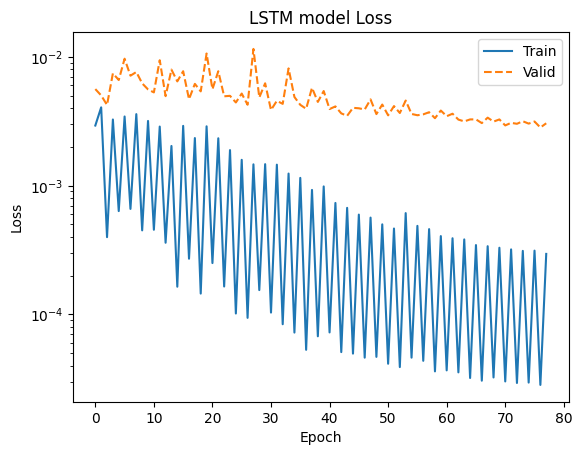

In [31]:
plot_loss(history)

In [32]:
results = lstm_model.evaluate(
    ds_train.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0016


In [33]:
baseline_results = lstm_model.evaluate(
    ds_valid.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.011520596221089363
compile_metrics : 0.0961008071899414


In [34]:
save_weights = False
if save_weights:
  lstm_model.save_weights(checkpoints_path)

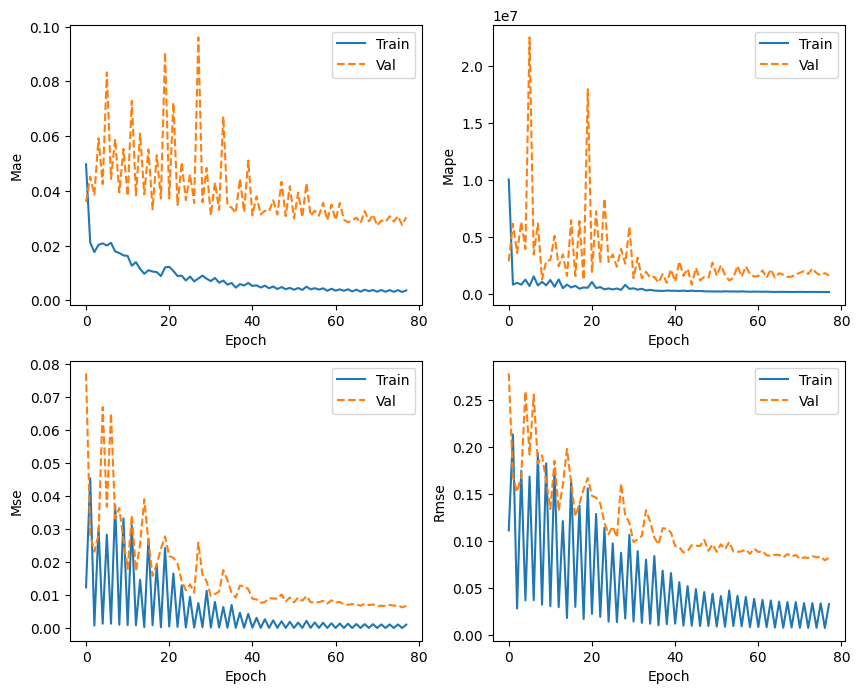

In [35]:
plot_metrics(history)

## 7. Отбор кандидатов для идеальной модели LSTM.

Предсказание идеального текущего значения по трем предшествующим периодам.

In [36]:
results = lstm_model.predict(ds_train.batch(BATCH_SIZE))
results.shape

240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step


(30684, 4, 3)

In [37]:
%%time
seq_true = generator.generate_model_inputs_df(train, temperature, df_stat)
seq_true.sample(2)

CPU times: user 8.64 s, sys: 138 ms, total: 8.78 s
Wall time: 12.9 s


,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input
3080,372,"г Уфа, пр-кт Октября, д.164",Многоквартирный дом,16037044,1,5.0,1963-01-01,7399.8,5-9 этажей,пр-кт Октября,1963-01-01,1959-1989 гг.,8900,4,"[(0.13246826222684704, 0.31116998547132724, 1)..."
11234,1546,"г Уфа, ул. Добролетная, д.7 корп.4",Многоквартирный дом,255022,1,2.0,1958-01-01,456.1,1-2 этажа,ул. Добролетная,1958-01-01,до 1958 г,2000,8,"[(0.02310093652445369, 0.20117938637723265, 1)..."


In [38]:
df = seq_true["LSTM input"].apply(lambda x: pd.Series(np.array(x).T[0].tolist()))
df.values.shape

(30684, 4)

In [39]:
a = abs(df.values - results[:, :, 0]).mean(axis=1) / df.values.mean(axis=1)
q = np.quantile(a, 0.7)
q

0.5132453213252117

In [40]:
selected_inputs_df = seq_true[a < q]

print(f"selected_inputs_df.shape = {selected_inputs_df.shape}\n")
selected_inputs_df.sample(2)

selected_inputs_df.shape = (21479, 15)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input
21272,3060,"г Уфа, ул. Пекинская, д.15 корп.1",Многоквартирный дом,84834,1,9.0,2009-01-01,6649.52,5-9 этажей,ул. Пекинская,2009-01-01,2001-2010 гг.,8900,2,"[(0.031345703125, 1.0, 0), (0.1122164090368608..."
10021,1370,"г Уфа, ул. Вологодская, д.7",Многоквартирный дом,114409,0,9.0,1987-01-01,3841.50,5-9 этажей,ул. Вологодская,1987-01-01,1959-1989 гг.,4300,4,"[(0.10591220850480108, 0.5267482677960414, 1),..."


In [41]:
disk = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/data/03_primary/"
selected_inputs_df.to_parquet(f"{disk}selected_inputs_df.parquet.gzip", compression="gzip")